# Simulación Modelo El Farol

## Descripción del modelo

En el presente modelo se tiene una población de $N$ individuos, los cuales toman decisiones a lo largo de $k$ iteraciones. Cada individuo puede decidir si acudirá o no al bar llamado El Farol, tomando esta decisión de manera independiente a los demás agentes. 

![title](ElFarol1.jpeg)![title](ElFarol2.jpeg)

Las decisiones en conjunto de todos los individuos de la población afectará la ganancia de cada uno de ellos. Si el total de acudientes supera un umbral $\mu$, entonces El Farol se congestionará y los individuos que hayan ido al bar no tendrán una buena experiencia. Por otro lado, si el total de los acudientes no supera este umbral $\mu$, entonces los individuos que hayan asistido podrán disfrutar su estadía en el bar. Adicionalmente, si el individuo no asiste al bar en una iteración dada será indiferente al estado de El Farol.

En consecuencia, cada agente intentará tomar la mejor decisión posible en cada iteración, con respecto a asistir o no al bar. Para lograr esto, tendrá memoria de 1 iteración. Es decir, el agente recordará la decisión que tomó en la iteración inmediatamente anterior, y la ganancia que obtuvo de la misma. Así, cada individuo empleará de manera diferente esta información, siguiendo diferentes estrategias que pueden variar dependiendo del éxito o fracaso que experiencie el agente en un momento dado.

## Implementación en Python

In [1]:
import pandas as pd
import random as rd
import numpy as np
import matplotlib.pyplot as plt
import redes
import ElFarolFunciones as F
import seaborn as sns

#### AGENTES 
Los agentes que se simularán tendrán 4 atributos:

**Estado**: Es la estrategia tomada por el agente y que puede ser ir al bar (1) o abstenerse de ir (0).

**Puntaje:** Puntaje obtenido. Hay tres posibilidades:

- **1** Si fue y la proporción de agentes que fueron fue menor que el $\mu $ determinado ($\mu=0.5$).
- **0**, si decidió no ir.
- **-1**, si fue y la proporción de agentes que fueron fue mayor que el $\mu$ determinado ($\mu=0.5$).

**Politica**: Es la forma en que los agentes toman la decisión de actuar en la siguiente ronda dada la situación actual, en términos de su estado y puntaje.

**Vecinos:** Los vecinos son los agentes conectados mediante la red. Son los únicos sobre los que un agente puede tener información, en términos de puntaje y política.

La impementación en Python de estos atributos tiene la característica siguiente. Cada atributo se almacena como una lista, la cual guarda la información correspondiente por cada ronda. Esto es, por ejemplo, `agente.estado[0]` es el estado del agente en la primera ronda.

In [2]:
class agente:
    def __init__(self, estados, scores, politicas, vecinos):
        self.estado = estados # lista
        self.score = scores # lista
        self.politica = politicas # lista
        self.vecinos = vecinos

    def __str__(self):
        return "E:{0}, S:{1}, P:{2}, V{3}".format(self.estado, self.score,self.politica,self.vecinos)

Utilizando la clase **agente** podemos generar agentes aleatorios creando objetos de esta clase a los que se les asigna un estado y una política al azar. Una vez conocido el estado inicial de todos los agentes, se procede a calcular la proporción de agentes que fueron al bar, mediante la función `calculamedio()`. Dependiendo de este resultado, se le asigna un puntaje a cada agente. Así pues, esta función recibe como parámetro el número de agentes que se quieren crear y retorna una lista con los agentes nuevos.

In [3]:
def crear_agentes_aleatorios(Num_agentes):
    Agentes = []
    for i in range(Num_agentes):
        Agentes.append(agente([rd.randint(0,1)], [], [rd.randint(0,7)], []))

    X = F.calcula_medio(Agentes)
    
    for a in Agentes:
        if a.estado[-1] == 1:
            if X > 0.5:
                a.score.append(-1)
            else:
                a.score.append(1)
        else:
            a.score.append(0)

    return Agentes

Recordemos que las políticas representan la toma de decisiones de los agentes de la ronda $n$ a la ronda $n+1$. Para ello, cada agente consulta tanto la estrategia de la ronda $n$, como la recompensa obtenida. En nuestro modelo sólo hay tres posibles combinaciones de estrategias y recompensas, a saber:

(no ir a El Farol, recompensa 0) 
(ir a El Farol, recompensa 1) 
(ir a El Farol, recompensa -1)

Estas combinaciones se codifican de la siguiente manera, teniendo en cuenta que no ir al bar es 0 e ir es 1:

(0, 0)  
(1, 1)   
(1, -1)

Para cada combinación, el agente tiene dos opciones en la ronda $n+1$: ir o no ir. Esto nos da nueve políticas posibles.

In [4]:
def crear_politicas():
    politicas = [
    {(0,0): 0, (1,1): 0, (1, -1): 0}, #0
    {(0,0): 0, (1,1): 0, (1, -1): 1}, #1
    {(0,0): 0, (1,1): 1, (1, -1): 0}, #2
    {(0,0): 0, (1,1): 1, (1, -1): 1}, #3
    {(0,0): 1, (1,1): 0, (1, -1): 0}, #4
    {(0,0): 1, (1,1): 0, (1, -1): 1}, #5
    {(0,0): 1, (1,1): 1, (1, -1): 0}, #6
    {(0,0): 1, (1,1): 1, (1, -1): 1}, #7
    ]
    return politicas


Si queremos que haya más interacción entre los agentes, se utiliza la 
función `agentes_aprenden` la cual recibe como parámetro la lista de
agentes y compara el resultado de la última ronda con el de sus vecinos.
Cada agente se acoge a la política del vecino con mayor puntaje, si nadie tiene
un mejor puntaje continúa con la política que tenía.

In [5]:
def agentes_aprenden(Agentes):
    #Los agentes copian la politica del ganador de la Ronda
    for agente in Agentes:
        #print(Agentes.index(agente))
        maximo=agente.score[-1]
        maximo_vecino=Agentes.index(agente)
        #print(agente.vecinos)
        for index_vecino in agente.vecinos:
            if((Agentes[index_vecino].score[-1])>(maximo)):
                #print('Hay cambio')
                #print('Puntaje anterior',maximo)
                maximo=Agentes[index_vecino].score[-1]
                #print('Puntaje anterior vecino',maximo)
                maximo_vecino=index_vecino
            else: print('')
                #print('No hay cambio')
        agente.politica.append(Agentes[maximo_vecino].politica[-1])
    return Agentes

In [7]:
Num_iteraciones = 100
TIPO_RED = 0 # COMPLETA

DIBUJAR LA RED (igraph)

In [7]:
def simulacion(Num_agentes, Num_iteraciones, UMBRAL, inicial, N, PARS):

    agentes = crear_agentes_aleatorios(Num_agentes)

    politicas = crear_politicas()


    # Leyendo red de archivo
    F.leer_red(agentes)

    for i in range(Num_iteraciones):
        agentes = F.juega_ronda(agentes, politicas, UMBRAL)
        agentes = agentes_aprenden(agentes)

    data = F.crea_dataframe_agentes(agentes, Num_iteraciones, PARS, N)
    data['Politica_lag'] = data.groupby('Agente')['Politica'].transform('shift', 1)
    data['Consistencia'] = data.apply(lambda x : F.encontrar_consistencia (x['Politica'], x['Politica_lag']), axis=1)
    F.guardar(data, 'agentes_pol.csv', inicial)


## Correr simulación

In [8]:
Num_agentes = 100
identificador = 0
UMBRAL = 0.5
inicial = True

for i in range(2,Num_agentes+1):
    PARS = [i, 1]

    # Generando red a archivo
    if TIPO_RED == 0:
    # print('---------')
    # print('Parametros red:', PARS)
    # print('---------')
        redes.random_graph(*PARS)
    elif TIPO_RED == 1:
        redes.small_world(*PARS)
    elif TIPO_RED == 2:
        redes.scale_free(PARS[0], PARS[0]/4, PARS[0]/8, PARS[1]*0.6, PARS[1])

    simulacion(
        i, 
        Num_iteraciones, 
        UMBRAL, 
        inicial, 
        i, 
        PARS
        )



In [3]:
import copy

# Comando para mostrar gráficos en notebook
%matplotlib inline

# Comando para leer a partir de datos
data = pd.read_csv('agentes_pol.csv')
data

,Identificador,Agente,Ronda,Estado,Puntaje,Politica,Parametro-0,Parametro-1,Politica_lag,Consistencia
0,2,0,0,1,-1,3,2,1,NaN,NaN
1,2,0,1,1,-1,3,2,1,3.0,1.0
2,2,0,2,1,-1,3,2,1,3.0,1.0
3,2,0,3,1,-1,3,2,1,3.0,1.0
4,2,0,4,1,-1,3,2,1,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...
252543,100,99,45,0,0,4,100,1,4.0,1.0
252544,100,99,46,1,-1,4,100,1,4.0,1.0
252545,100,99,47,0,0,4,100,1,4.0,1.0
252546,100,99,48,1,-1,4,100,1,4.0,1.0


####  Asistencia por ronda

In [4]:
data.drop(data[data["Identificador"]=="Identificador"].index,inplace=True)

In [8]:
data = data.astype(float) # Como tenia antes identificador, los reconocia como strings, entonces era necesario volver a pasar a numerico para poder utilziarlo
data = data[data["Ronda"]==(Num_iteraciones-1)] #Seleccionando solo la ultima iteracion

In [9]:
data

,Identificador,Agente,Ronda,Estado,Puntaje,Politica,Parametro-0,Parametro-1,Politica_lag,Consistencia
49,2.0,0.0,49.0,1.0,-1.0,3.0,2.0,1.0,3.0,1.0
99,2.0,1.0,49.0,1.0,-1.0,7.0,2.0,1.0,7.0,1.0
150,3.0,0.0,49.0,1.0,1.0,3.0,3.0,1.0,3.0,1.0
200,3.0,1.0,49.0,0.0,0.0,3.0,3.0,1.0,3.0,1.0
250,3.0,2.0,49.0,0.0,0.0,3.0,3.0,1.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...
252347,100.0,95.0,49.0,1.0,1.0,5.0,100.0,1.0,5.0,1.0
252397,100.0,96.0,49.0,0.0,0.0,4.0,100.0,1.0,4.0,1.0
252447,100.0,97.0,49.0,0.0,0.0,4.0,100.0,1.0,4.0,1.0
252497,100.0,98.0,49.0,0.0,0.0,4.0,100.0,1.0,4.0,1.0


In [10]:
data_ident=data.groupby(['Identificador','Ronda'])
data_ident.head()
df1=data_ident

In [24]:
df = pd.DataFrame(data.groupby(['Identificador','Ronda','Politica'])['Agente'].count()).reset_index()
df.columns = ['Identificador','Ronda', 'Politica', 'num_agentes']
df["porcentaje"] = df["num_agentes"]/df["Identificador"]
df.head()

,Identificador,Ronda,Politica,num_agentes,porcentaje
0,2.0,49.0,3.0,1,0.5
1,2.0,49.0,7.0,1,0.5
2,3.0,49.0,3.0,3,1.0
3,4.0,49.0,1.0,4,1.0
4,5.0,49.0,7.0,5,1.0


In [25]:
uso_politica = pd.pivot_table(
    data=df,
    index='Identificador',
    values='porcentaje',
    columns='Politica',
    aggfunc='sum'
).reset_index()

uso_politica.index.names=['num_agentes']
#uso_politica = uso_politica.apply(lambda x :x/float(x.index),axis=1)
del uso_politica['Identificador']
#uso_politica.columns = ['Ronda', '0', '1', '2', '3', '4', '5', '6', '7']
#uso_politica = uso_politica.iloc[:-1]
#uso_politica['Ronda'] = uso_politica['Ronda'].apply(lambda x: int(x))
uso_politica = uso_politica.sort_values(by='num_agentes',ascending=False)
uso_politica.fillna(0,inplace=True)
uso_politica.head()

Politica,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
num_agentes,,,,,,,,
98,0.0,0.0,0.0,0.0,0.940000,0.060000,0.0,0.0
97,0.0,0.0,0.0,0.0,0.909091,0.090909,0.0,0.0
96,0.0,0.0,0.0,0.0,0.969388,0.030612,0.0,0.0
95,0.0,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0
94,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0


### Mapa de calor de Numero de agentes (0=2,Num_agentes -1)

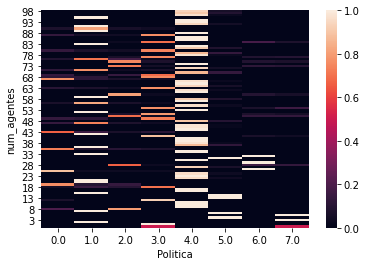

In [26]:
ax = sns.heatmap(uso_politica)

#### Consistencia Individual